In [48]:
import os
import numpy as np
import pandas
import seaborn as sns
import matplotlib.pyplot as plt

In [62]:
#paths
data_path = './data'
figures_path = './figures'

In [21]:
files = np.sort(np.array(os.listdir(data_path)))
files = [file for file in files if 'order' not in file]
paired_files = [(files[i], files[i+1]) for i in range(0, len(files)-1, 2)]

data_df = pandas.DataFrame({})

for imagery_score, playlist_timestamps in paired_files:
    #supplemental run data 
    subject = imagery_score[:6]
    run_i = imagery_score.find('run-')+len('run-')
    run = imagery_score[run_i:run_i+2]
    run = int(run[0]) if run[-1] == '_' else int(run)
    session = int(imagery_score[imagery_score.find('ses-00')+len('ses-00')])
    
    subject_runs_order = 'S{}_Playlist_order.tsv'.format(subject[1:])
    order = pandas.read_csv(os.path.join(data_path, subject_runs_order), sep=' ')

        
    i = order.loc[(order['run']==run) & (order['session']==session)].index
    playlist = int(order.playlist.iloc[i].values[0])
    repetition = int(order.repetition.iloc[i].values[0])
    
    #extract data from tsv
    score_path = os.path.join(data_path, imagery_score)
    score_df = pandas.read_csv(score_path, sep='\t')
    timestamps_path = os.path.join(data_path, playlist_timestamps)
    timestamps_df = pandas.read_csv(timestamps_path, sep='\t')
    
    #manage df
    score_df.drop('question', axis='columns', inplace=True)
    timestamps_df.drop('path', axis='columns', inplace=True)
    run_df = pandas.concat([timestamps_df, score_df], axis='columns', join='outer')
    run_df.drop('track', axis='columns', inplace=True) 
    run_df['sub'] = subject
    run_df['run'] = run
    run_df['playlist'] = playlist
    run_df['repetition'] = repetition

    data_df = pandas.concat([data_df, run_df], axis='rows', join='outer', ignore_index=True)

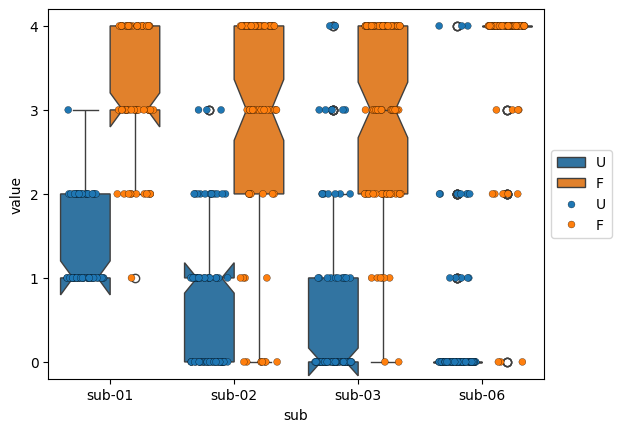

In [63]:
sns.boxplot(data=data_df, x="sub", y="value", hue="Groupe", notch=True)
sns.stripplot(data=data_df, x="sub", y="value", hue="Groupe", dodge=True, jitter=0.3, edgecolor='k', linewidth=0.2)
plt.legend(loc='center right', bbox_to_anchor=(1.15, 0.5))
plt.yticks(range(5))

plt.savefig(os.path.join(figures_path, 'ImaginationScore_Groupe'))

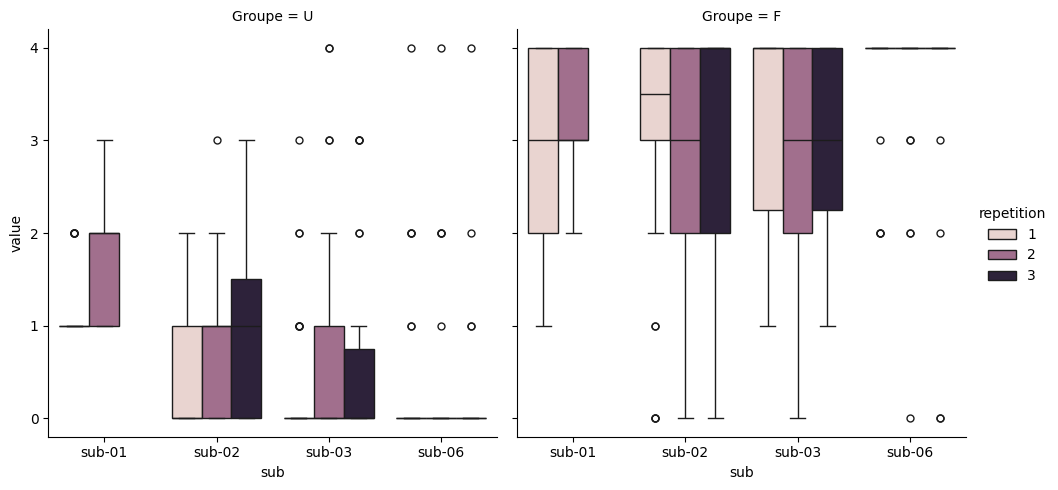

In [64]:
sns.catplot(data=data_df, x="sub", y="value", hue="repetition", col="Groupe", kind='box')
plt.yticks(range(5))
plt.savefig(os.path.join(figures_path, 'ImaginationScore_Groupe_Repetition'))

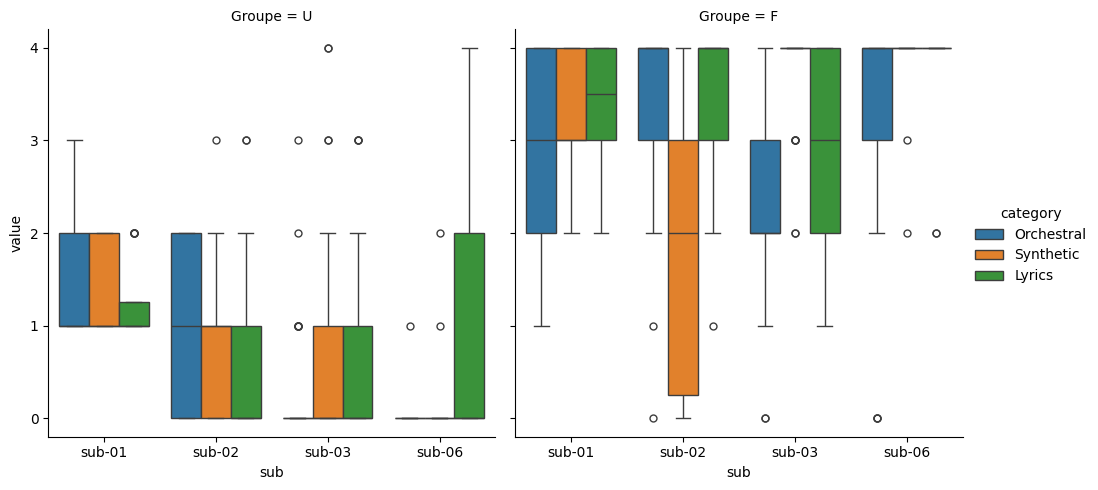

In [65]:
sns.catplot(data=data_df, x="sub", y="value", hue="category", col="Groupe", kind='box')
plt.yticks(range(5))
plt.savefig(os.path.join(figures_path, 'ImaginationScore_Groupe_Category'))

In [59]:
print(data_df)

    Groupe    category                                              title  \
0        U  Orchestral  Star_Trek_the_Next_Generation_(Main_Title)_sil...   
1        F   Synthetic  Super_Mario_Bros_(NES)_Music_Overworld_Theme_s...   
2        F      Lyrics     Everybody_Wants_To_Rule_The_World_silenced.wav   
3        U  Orchestral  Main_Title_Terminator_2_Theme_(Remastered_2017...   
4        U      Lyrics                         Synchronicity_silenced.wav   
..     ...         ...                                                ...   
626      U  Orchestral                        il_porco_rosso_silenced.wav   
627      F      Lyrics                        I_Will_Survive_silenced.wav   
628      F  Orchestral                    Stairway_To_Heaven_silenced.wav   
629      U      Lyrics  Cant_Live_With_You_Cant_Live_Without_You_silen...   
630      U      Lyrics              Why_You_Wanna_Trip_on_Me_silenced.wav   

     silence_duration  total_duration       onset  value confirmation     s